# Classification of Fruits and Vegies
I used the dataset of fruits and vegetables that was collected in our class. Instead of operating on the raw pixel values, I operate on extracted HSV colorspace histogram features from the image. HSV histogram features extract the color spectrum of an image, so I expect these features to serve well for distinguishing produce like bananas from apples.

# Part 1: Dimentionality Reduction
The input state x ∈ R^729, which is an HSV histogram generated from an RGB image with a fruit centered in it. Each data point will have a corresponding class label, which corresponds to their matching produce. Given 25 classes, I can denote the label as y ∈ {0, ..., 24}.


Classification here is still a hard problem because the state space is much larger than the amount of data we obtained in the class – I am trying to perform classification in a 729 dimensional space with only a few hundred data points from each of the 25 classes. In order to obtain higher accuracy, I will examine how to perform hyper-parameter optimization and dimensionality reduction. 

I will first build out each component and test on a smaller dataset of just 3 categories: apple, banana, eggplant. Then I will combine the components to perform a search over the entire dataset.


Before I classify our data, I will study how to reduce the dimensionality of our data. I will project some of the dataset into 2D to visualize how effective different dimensionality reduction procedures are. 

* random projection:  a matrix is randomly created and the data is linearly projected along it. For random projections, it produces a matrix, A ∈ R2×729 where each element Aij is sampled independently from a normal distribution (i.e. Aij ∼ N (0, 1)).

In [20]:

from numpy.random import uniform
from numpy.random import randn
import random
import time

import matplotlib.pyplot as plt

from scipy.linalg import eig
from scipy.linalg import sqrtm
from numpy.linalg import inv
from numpy.linalg import svd

from utils import create_one_hot_label
from utils import subtract_mean_from_data
from utils import compute_covariance_matrix

import numpy as np
import numpy.linalg as LA

import sys
from numpy.linalg import svd
import IPython

In [21]:
class Project2D():

    ''' Class to draw projection on 2D scatter space'''

    def __init__(self,projection, clss_labels):

        self.proj = projection
        self.clss_labels = clss_labels


    def project_data(self,X,Y,white=None):

        '''
        Takes list of state space and class labels
        State space should be 2D
        Labels shoud be int'''

        p_a = []
        p_b = []
        p_c = []

        ###PROJECT ALL DATA###
        proj = np.matmul(self.proj,white)
        X_P = np.matmul(proj,np.array(X).T)

        for i in range(len(Y)):
            if Y[i] == 0:
                p_a.append(X_P[:,i])
            elif Y[i] == 1:
                p_b.append(X_P[:,i])
            else:
                p_c.append(X_P[:,i])

        p_a = np.array(p_a)
        p_b = np.array(p_b)
        p_c = np.array(p_c)

        plt.scatter(p_a[:,0],p_a[:,1],label = 'apple')
        plt.scatter(p_b[:,0],p_b[:,1],label = 'banana')
        plt.scatter(p_c[:,0],p_c[:,1],label = 'eggplant')
        plt.legend()
        plt.show()


In [22]:
class Projections():

    def __init__(self,dim_x,classes):
        '''
        dim_x: the dimension of the state space x
        classes: The list of class labels'''

        self.d_x = dim_x
        self.NUM_CLASSES = len(classes)


    def get_random_proj(self):

        '''
        Return A which is size 2 by 729'''

        return randn(2,self.d_x)


    def pca_projection(self,X,Y):

        '''
        Return U_2^T '''
                
        X,Y= subtract_mean_from_data(X,Y)
        C_XX = compute_covariance_matrix(X,X)
        u,s,d = svd(C_XX)
        return u[:,0:2].T

    def cca_projection(self,X,Y,k=2):

        '''
        Return U_K^T, \Simgma_{XX}^{-1/2} '''

        Y = create_one_hot_label(Y,self.NUM_CLASSES)
        X,Y = subtract_mean_from_data(X,Y)


        C_XY = compute_covariance_matrix(X,Y)
        C_XX = compute_covariance_matrix(X,X)
        C_YY = compute_covariance_matrix(Y,Y)

        dim_x = C_XX.shape[0]
        dim_y = C_YY.shape[0]

        A = inv(sqrtm(C_XX+1e-5*np.eye(dim_x)))
        B = inv(sqrtm(C_YY+1e-5*np.eye(dim_y)))
        C = np.matmul(A,np.matmul(C_XY,B))

        u,s,d = svd(C)
        return u[:,0:k].T, A

    def project(self,proj,white,X):
        '''
        proj, numpy matrix to perform projection
        whit, numpy matrix to perform whitenting
        X, list of states
        '''

        proj = np.matmul(proj,white)
        X_P = np.matmul(proj,np.array(X).T)
        return list(X_P.T)

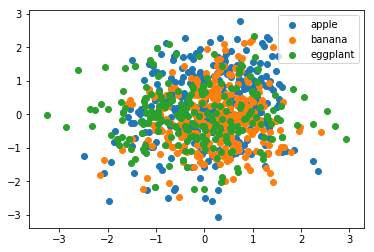

In [23]:
# Load Training Data and Labels
X = list(np.load('little_x_train.npy'))
Y = list(np.load('little_y_train.npy'))

# Load Validation Data and Labels
X_val = list(np.load('little_x_val.npy'))
Y_val = list(np.load('little_y_val.npy'))

CLASS_LABELS = ['apple','banana','eggplant']

feat_dim = max(X[0].shape)
projections = Projections(feat_dim,CLASS_LABELS)


#Show Random 2D Projection
rand_proj = projections.get_random_proj()
proj2D_viz = Project2D(rand_proj,CLASS_LABELS)
proj2D_viz.project_data(X,Y, white = np.eye(feat_dim))

* PCA: projects the data into the subspace with the most variance, which is determined via the co- variance matrix ΣXX. We can compute the principal components via the singular value de- composition UΛV T = ΣXX.

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


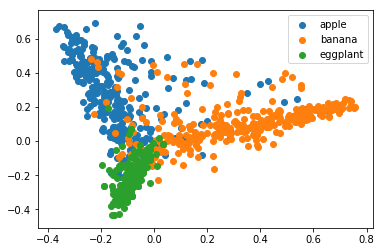

In [24]:
#PCA Projection
pca_proj = projections.pca_projection(X,Y)
proj2D_viz = Project2D(pca_proj,CLASS_LABELS)
proj2D_viz.project_data(X,Y, white = np.eye(feat_dim))

* CCA:
we must first turn our labels y into a one-hot encoding vector y ∈ {0, 1}J, where each elementcorresponds to the label. Note J is the number of class labels, which is J = 3 for this part. Next we need to compute the canonical correlation matrix ΣXX^{-1/2}ΣXY ΣYY^{-1/2}. and compute the singular value decomposition.

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


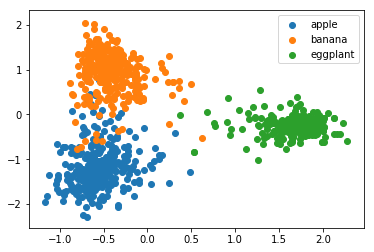

In [25]:
#Show CCA 2D Projection
cca_proj,white_cov = projections.cca_projection(X,Y)
proj2D_viz = Project2D(cca_proj,CLASS_LABELS)
proj2D_viz.project_data(X,Y,white = white_cov)

Conclusion: Among the dimension reduction methods I have tried, CCA  is the best for separation among classes, so I decide to use CCA to extract effective features. 

In [26]:
X = projections.project(cca_proj,white_cov,X)
X_val = projections.project(cca_proj,white_cov,X_val)

# Part 1: Classification
We will now examine ways to perform classification using the smaller projected space from CCA as our features.

First let's define Generic wrapper for specific model instance.

In [27]:
from numpy.random import uniform
from numpy.random import uniform
import random
import time


import numpy as np
import numpy.linalg as LA

import sys

from sklearn.linear_model import Ridge

from utils import create_one_hot_label

import matplotlib.pyplot as plt

In [28]:
class Model():
    """ Generic wrapper for specific model instance. """

    def __init__(self, model):
        """ Store specific pre-initialized model instance. """
        self.model = model


    def train_model(self,X,Y): 
        """ Train using specific model's training function. """
        self.model.train_model(X,Y)
        
    def test_model(self,X,Y):
        """ Test using specific model's eval function. """
        if hasattr(self.model, "evals"):
            labels = np.array(Y)
            p_labels = self.model.evals(X)
        else:
            labels = []                         # List of actual labels
            p_labels = []                       # List of model's predictions
            success = 0                         # Number of correct predictions
            total_count = 0                     # Number of images

            for i in range(len(X)):
                x = X[i]                        # Test input
                y = Y[i]                        # Actual label
                y_ = self.model.eval(x)         # Model's prediction
                labels.append(y)
                p_labels.append(y_)

                if y == y_:
                    success += 1
                total_count +=1                 
                
        print("Computing Confusion Matrix")
        # Compute Confusion Matrix
        getConfusionMatrixPlot(labels,p_labels,CLASS_LABELS)

The define a function to plot the confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix

def main():
    """
    Result
    Plot RANDOM confusion matrix (true labels vs. predicted labels)
    """
    true_labels = [random.randint(1, 10) for i in range(100)]
    predicted_labels = [random.randint(1, 10) for i in range(100)]

    # Plot confusion matrix (true labels vs. predicted labels)
    plot = getConfusionMatrixPlot(true_labels, predicted_labels)
    plot.show()


def getConfusionMatrix(true_labels, predicted_labels):
    """
    Input
    true_labels: actual labels
    predicted_labels: model's predicted labels

    Output
    cm: confusion matrix (true labels vs. predicted labels)
    """

    # Generate confusion matrix using sklearn.metrics
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm


def plotConfusionMatrix(cm, alphabet):
    """
    Input
    cm: confusion matrix (true labels vs. predicted labels)
    alphabet: names of class labels

    Output
    Plot confusion matrix (true labels vs. predicted labels)
    """

    fig = plt.figure()
    plt.clf()                       # Clear plot
    ax = fig.add_subplot(111)       # Add 1x1 grid, first subplot
    ax.set_aspect(1)
    res = ax.imshow(cm, cmap=plt.cm.binary, interpolation='nearest', vmin=0, vmax=80)

    plt.colorbar(res)               # Add color bar

    width = len(cm)                 # Width of confusion matrix
    height = len(cm[0])             # Height of confusion matrix

    # Annotate confusion entry with numeric value
    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))


    # Plot confusion matrix (true labels vs. predicted labels)
    plt.xticks(range(width), alphabet[:width], rotation=90)
    plt.yticks(range(height), alphabet[:height])
    plt.show()
    return plt


def getConfusionMatrixPlot(true_labels, predicted_labels, alphabet):
    """
    Input
    true_labels: actual labels
    predicted_labels: model's predicted labels
    alphabet: names of class labels

    Output
    Plot confusion matrix (true labels vs. predicted labels)
    """

    # Generate confusion matrix using sklearn.metrics
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

    # Plot confusion matrix (true labels vs. predicted labels)
    return plotConfusionMatrix(cm, alphabet)


def getFontColor(value):
    """
    Input
    value: confusion entry value

    Output
    font color for confusion entry
    """
    if value < -1:
        return "black"
    else:
        return "white"




* Ridge Regression:

In [30]:
class Ridge_Model(): 

    def __init__(self,class_labels):
        self.lmbda = 1.0
        self.NUM_CLASSES = len(class_labels)
                
    def train_model(self,X,Y): 
        Y_one_hot = create_one_hot_label(Y,self.NUM_CLASSES)
        self.ridge = Ridge(alpha=self.lmbda)
        self.ridge.fit(X,Y_one_hot)

    def eval(self,x):
        x = np.array(x)
        if len(x.shape)==1:
            x = np.reshape(x, (1, -1))
        prediction = self.ridge.predict(x)
        return np.argmax(prediction)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Computing Confusion Matrix
[[310  15   0]
 [ 10 298   1]
 [  2   0 240]]


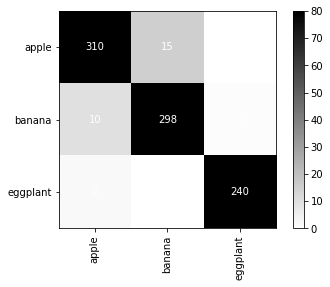

Computing Confusion Matrix
[[83 17  3]
 [ 6 98  4]
 [ 9  8 76]]


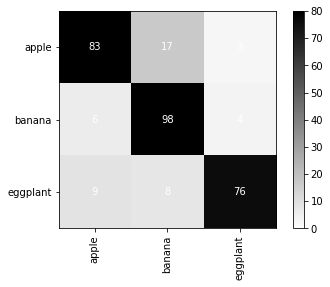

In [32]:
ridge_m = Ridge_Model(CLASS_LABELS)
model = Model(ridge_m)

model.train_model(X,Y)
model.test_model(X,Y)
model.test_model(X_val,Y_val)

* LDA： assuming each p(x|y = j) is a normal distribution with mean μj and covariance Σ. Notice that the covariance matrix is assumed to be the same for all the class labels. LDA works by fitting μj and Σ on the dimensionality-reduced dataset. During prediction, the class with the highest likelihood is chosen.

In [33]:
class LDA_Model():

    def __init__(self,class_labels):
        ###SCALE AN IDENTITY MATRIX BY THIS TERM AND ADD TO COMPUTED COVARIANCE MATRIX TO PREVENT IT BEING SINGULAR ###
        self.reg_cov = 0.001
        self.NUM_CLASSES = len(class_labels)



    def train_model(self,X,Y): 
        ''''
        FILL IN CODE TO TRAIN MODEL
        MAKE SURE TO ADD HYPERPARAMTER TO MODEL 
        '''
        self.u = []
        for i in range(self.NUM_CLASSES):
            idx = np.where(np.array(Y)==i)[0]
            self.u.append(np.mean(np.array(X)[idx], axis=0))
        self.sig = np.cov(np.array(X).T)
        self.sig += np.identity(len(self.sig))*self.reg_cov
            

    def eval(self,x):
        ''''
        Fill in code to evaluate model and return a prediction
        Prediction should be an integer specifying a class
        '''
        y = []
        for i in range(self.NUM_CLASSES): 
            y.append((x-self.u[i]) @ inv(self.sig) @ (x-self.u[i]).T)
        return np.argmin(y)

 

Computing Confusion Matrix
[[310  15   0]
 [ 10 298   1]
 [  2   1 239]]


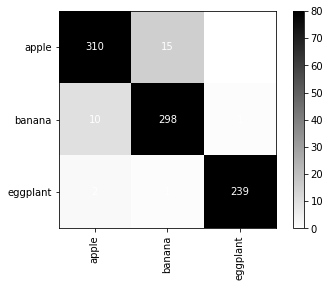

Computing Confusion Matrix
[[83 17  3]
 [ 6 99  3]
 [ 9  9 75]]


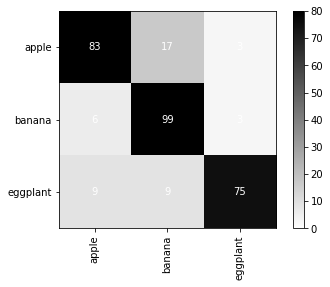

In [35]:
lda_m = LDA_Model(CLASS_LABELS)
model = Model(lda_m)

model.train_model(X,Y)
model.test_model(X,Y)
model.test_model(X_val,Y_val)

* QDA： LDA makes an assumption that all classes have the same covariance matrix. We can relax this assumption with QDA. In QDA, we will now parametrize each conditional distribution (still normal) by μj and Σj . 

In [37]:
class QDA_Model(): 
    def __init__(self,class_labels):
        ###SCALE AN IDENTITY MATRIX BY THIS TERM AND ADD TO COMPUTED COVARIANCE MATRIX TO PREVENT IT BEING SINGULAR ###
        self.reg_cov = 0.01
        self.NUM_CLASSES = len(class_labels)



    def train_model(self,X,Y): 
        ''''
        FILL IN CODE TO TRAIN MODEL
        MAKE SURE TO ADD HYPERPARAMTER TO MODEL 

        '''
        self.u = []
        self.sig = []
        for i in range(self.NUM_CLASSES):
            idx = np.where(np.array(Y)==i)[0]
            self.u.append(np.mean(np.array(X)[idx], axis=0))
            sig = np.cov(np.array(X)[idx].T)
            sig += np.identity(len(sig))*self.reg_cov
            self.sig.append(sig)

    def eval(self,x):
        ''''
        Fill in code to evaluate model and return a prediction
        Prediction should be an integer specifying a class
        '''
        y = []
        for i in range(self.NUM_CLASSES): 
            y.append((x-self.u[i]) @ inv(self.sig[i]) @ (x-self.u[i]).T + np.log(det(self.sig[i])))
        return np.argmin(y)


 

Computing Confusion Matrix
[[311  14   0]
 [  9 299   1]
 [  2   1 239]]


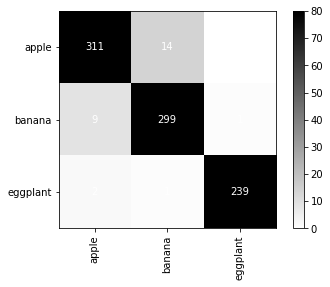

Computing Confusion Matrix
[[83 17  3]
 [ 6 99  3]
 [ 9  9 75]]


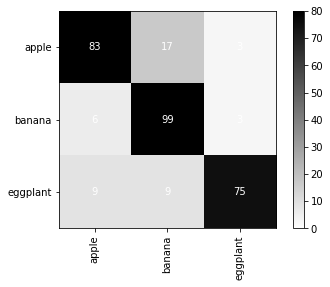

In [39]:
from numpy.linalg import det

qda_m = QDA_Model(CLASS_LABELS)
model = Model(qda_m)

model.train_model(X,Y)
model.test_model(X,Y)
model.test_model(X_val,Y_val)

* Linear SVM: fits a hyperplane to separate the dimensionality-reduced data.

In [43]:
from sklearn.svm import LinearSVC
class SVM_Model(): 
    def __init__(self,class_labels,projection=None):
        self.C = 1.0
                
    def train_model(self,X,Y): 
        self.svm = LinearSVC(C=self.C)
        self.svm.fit(X,Y)
                
    def eval(self,x):
        prediction = self.svm.predict(np.array([x]))
        return prediction[0]

    def scores(self, x):
        return self.svm.decision_function(np.array(x))




/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Computing Confusion Matrix
[[311  14   0]
 [ 10 298   1]
 [  2   1 239]]


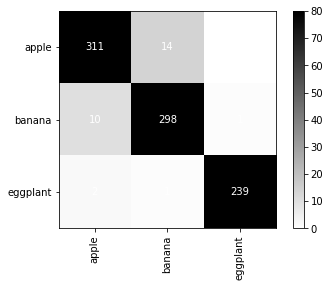

Computing Confusion Matrix
[[83 17  3]
 [ 7 97  4]
 [ 7  9 77]]


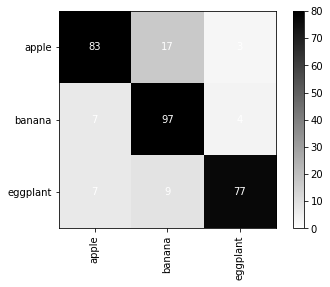

In [44]:
svm_m = SVM_Model(CLASS_LABELS)
model = Model(svm_m)

model.train_model(X,Y)
model.test_model(X,Y)
model.test_model(X_val,Y_val)

* Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression

class Logistic_Model(): 
    def __init__(self,class_labels,projection=None):
        self.C = 1.0

    def train_model(self,X,Y): 
        self.lr = LogisticRegression(C=self.C)
        self.lr.fit(X,Y)
                
    def eval(self,x):
        prediction = self.lr.predict(np.array([x]))
        return prediction[0]

    def scores(self, x):
        return self.lr.decision_function(np.array(x))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Computing Confusion Matrix
[[311  14   0]
 [ 10 298   1]
 [  2   0 240]]


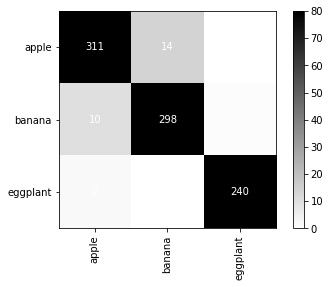

Computing Confusion Matrix
[[83 17  3]
 [ 7 97  4]
 [ 9  7 77]]


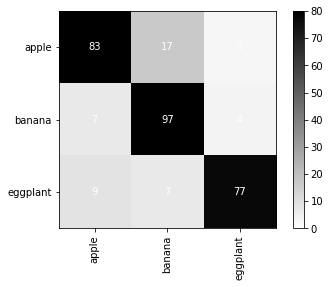

In [48]:
lr_m = Logistic_Model(CLASS_LABELS)
model = Model(lr_m)

model.train_model(X,Y)
model.test_model(X,Y)
model.test_model(X_val,Y_val)

# Part 3: Understanding Classifier's performance using ROC

In a two class classification problem, we can compare the prediction to the labels. Specifically, we count the number of True Positives (TP), False Positives (FP), False Negatives (FN) and True Negatives (TN). 

The true positive rate (TPR) measures how many positive examples out of all positive examples have been detected, con- cretely, TPR = TP/(TP+FN). The false positive rate (FPR) measures the proportion of negative examples that are mistakenly classified as positive, concretely, FPR = FP/(FP + TN).

A perfect classifier would have TPR = 1.0 and FPR = 0.0. However, in the real world, we usually do not have such a classifier. Requiring a higher TPR usually incurs the cost of a higher FPR, since that makes the classifier predict more positive outcomes. An ROC plots the trade off between TPR and FPR in a graphical manner. One way to get an ROC curve is to first obtain a set of scalar prediction scores, one for each of the validation samples. A higher score means that the classifier believes the sample is more likely to be a positive example. For each of the possible thresholds for the classifier, we can compute the TPR and FPR. After getting all (TPR, FPR) pairs, we can plot the ROC curve. 

In [50]:
def compute_tp_fp(thres, scores, labels):
    """ Calculate TPR and FPR"""
    scores = np.array(scores)
    prediction = (scores > thres)
    tp = np.sum(prediction * labels)
    tpr = 1.0 * tp / np.sum(labels)

    fp = np.sum(prediction * (1-labels))
    fpr = 1.0*fp / np.sum(1-labels)
    return tpr, fpr

def plot_ROC(tps, fps):
    """plot tpr VS fpr"""
    plt.plot(fps, tps)
    plt.ylabel("True Positive Rates")
    plt.xlabel("False Positive Rates")
        


def ROC(scores, labels):
    """calculate tps and fps at different threshold"""
    thresholds = sorted(np.unique(scores))
    thresholds = [-float("Inf")] + thresholds + [float("Inf")]
    tps = []
    fps = []

    for thres in thresholds:
        tpr, fpr = compute_tp_fp(thres, scores, labels)
        tps.append(tpr)
        fps.append(fpr)
    return tps, fps
        

def eval_with_ROC(method, train_X, train_Y, val_X, val_Y, C):
    m = method(CLASS_LABELS)
    m.C = C
    m.train_model(train_X, train_Y)
    scores = m.scores(val_X)

    # change the scores here
    scores = 10.0 * np.array(scores)
    tps, fps = ROC(scores, val_Y)
    plot_ROC(tps, fps)

def trim_data(X, Y):
    # throw away the 3rd class data
    X = np.array(X)
    Y = np.array(Y)
    retain = (Y < 2)
    return X[retain, :], Y[retain]



/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


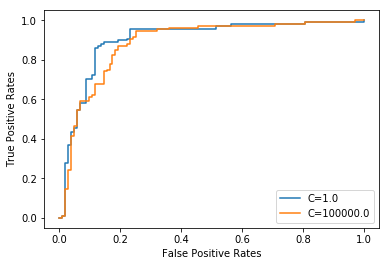

In [51]:
# Load Training Data and Labels
X = list(np.load('little_x_train.npy'))
Y = list(np.load('little_y_train.npy'))
X, Y = trim_data(X, Y)

# Load Validation Data and Labels
X_val = list(np.load('little_x_val.npy'))
Y_val = list(np.load('little_y_val.npy'))
X_val, Y_val = trim_data(X_val, Y_val)

CLASS_LABELS = ['apple','banana']

# Project Data to 200 Dimensions using CCA
feat_dim = max(X[0].shape)
projections = Projections(feat_dim,CLASS_LABELS)
cca_proj,white_cov = projections.cca_projection(X,Y,k=2)

X = projections.project(cca_proj,white_cov,X)
X_val = projections.project(cca_proj,white_cov,X_val)


####RUN SVM REGRESSION#####
eval_with_ROC(SVM_Model, X, Y, X_val, Y_val, 1.0)
eval_with_ROC(SVM_Model, X, Y, X_val, Y_val, 100000.0)
plt.legend(["C=1.0", "C=100000.0"])
plt.show()

From this plot, we can see C=1.0 is a better choice.

# part 4: Classification for full dataset
We will finally train on the full dataset and compare the different models. We will perform a grid search over the following hyperparameters:
(a) The regularization term λ in Ridge Regression.
(b) The weighting on slack variables, C in the linear SVM. 
(c) The number of dimensions, k we project to using CCA.


In [53]:
CLASS_LABELS = ['apple','banana','nectarine','plum','peach','watermelon','pear','mango','grape','orange','strawberry','pineapple', 
        'radish','carrot','potato','tomato','bellpepper','broccoli','cabbage','cauliflower','celery','eggplant','garlic','spinach','ginger']

def eval_model(X,Y,k,model_key,proj):
    # PROJECT DATA 
    cca_proj,white_cov = proj.cca_projection(X,Y,k=k)

    X_p = proj.project(cca_proj,white_cov,X)
    X_val_p = proj.project(cca_proj,white_cov,X_val)

    # TRAIN MODEL 
    model = models[model_key]

    model.train_model(X_p,Y)
    acc,cm = model.test_model(X_val_p,Y_val)

    return acc,cm


class Model(): 
    """ Generic wrapper for specific model instance. """


    def __init__(self,model):
        """ Store specific pre-initialized model instance. """

        self.model = model


    def train_model(self,X,Y): 
        """ Train using specific model's training function. """
                
        self.model.train_model(X,Y)
        

    def test_model(self,X,Y):
        """ Test using specific model's eval function. """
        if hasattr(self.model, "evals"):
            labels = np.array(Y)
            p_labels = self.model.evals(X)
            success =np.sum(labels == p_labels)
            total_count = len(X)

        else:
            labels = []                        # List of actual labels
            p_labels = []                      # List of model's predictions
            success = 0                        # Number of correct predictions
            total_count = 0                    # Number of images

            for i in range(len(X)):
                                
                x = X[i]                       # Test input
                y = Y[i]                       # Actual label
                y_ = self.model.eval(x)        # Model's prediction
                labels.append(y)
                p_labels.append(y_)

                if y == y_:
                    success += 1
                    total_count +=1                         
                
        return 1.0*success/total_count, getConfusionMatrix(labels,p_labels)



In [ ]:
        # Load Training Data and Labels
        X = list(np.load('big_x_train.npy'))
        Y = list(np.load('big_y_train.npy'))

        # Load Validation Data and Labels
        X_val = list(np.load('big_x_val.npy'))
        Y_val = list(np.load('big_y_val.npy'))


        # Project Data to 200 Dimensions using CCA
        feat_dim = max(X[0].shape)
        projections = Projections(feat_dim,CLASS_LABELS)
        


        models = {}               # Dictionary of key: model names, value: model instance

        #########MODELS TO EVALUATE############
        qda_m = QDA_Model(CLASS_LABELS)
        models['qda'] =  Model(qda_m)

        lda_m = LDA_Model(CLASS_LABELS)
        models['lda'] = Model(lda_m)

        ridge_m = Ridge_Model(CLASS_LABELS)
        models['ridge'] = Model(ridge_m)

        ridge_m_10 = Ridge_Model(CLASS_LABELS)
        ridge_m.lmbda = 10.0
        models['ridge_lmda_10'] = Model(ridge_m_10)

        ridge_m_01 = Ridge_Model(CLASS_LABELS)
        ridge_m.lmbda = 0.1
        models['ridge_lmda_01'] = Model(ridge_m_01)

        svm_m = SVM_Model(CLASS_LABELS)
        models['svm'] = Model(svm_m)

        svm_m_10 = SVM_Model(CLASS_LABELS)
        svm_m.C = 10.0
        models['svm_C_10'] = Model(svm_m_10)

        svm_m_01 = SVM_Model(CLASS_LABELS)
        svm_m.C = 0.1
        models['svm_C_01'] = Model(svm_m_01)




        #########GRID SEARCH OVER MODELS############
        highest_accuracy = 0                    # Highest validation accuracy
        best_model_name = None                  # Best model name
        best_model = None                               # Best model instance

        K = [50,200,600,800]                    # List of dimensions


        for model_key in models.keys():
            print(model_key)
                
            val_acc = []                    # List of model's accuracies for each dimension 
            for k in K:
                print("k =", k)
                        
                # Evaluate specific model's validation accuracy on specific dimension
                acc,c_m = eval_model(X,Y,k,model_key,projections)

                val_acc.append(acc)

                if acc > highest_accuracy: 
                    highest_accuracy = acc
                    best_model_name = model_key
                    best_cm = c_m
                                
            # Plot specific model's accuracies across validation error
            plt.plot(K,val_acc,label=model_key)


        # Display aggregate plot of models across validation error
        plt.legend()
        plt.xlabel('Dimension') 
        plt.ylabel('Accuracy') 
        plt.show()


        # Plot best model's confusion matrix
        plotConfusionMatrix(best_cm,CLASS_LABELS)
 

qda
k = 50
k = 200
k = 600


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


k = 800
